## Introduction

On se lance dans le projet *N-body*. Il est conseillé d'utiliser C++, et c'est effectivement ce que nous allons faire. Néanmoins, pour des raisons pratiques, tous les plots seront faits en Python au travers de fichiers .txt.

Sans plus attendre, on va pouvoir se lancer dans les premières tâches du projet!

In [2]:
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import curve_fit
from scipy.stats import gaussian_kde
from fancy_package import *

plt.style.use("ggplot")


___

## 1. First Task

On reste tranquillement en Python !

### 1.1. Première étape

* [X] Vérifier la forme de la fonction de densité $\rho(r)$. Comparer à la densité décrite dans le papier.
* [X] Check les choix d'unités, une fois que l'on a fixé G = 1.

La première étape est simplement de jeter un oeil au fichier `data.txt`.

In [ ]:
# let's save the file as a csv file that will be easier to read!
df = pd.read_csv("../files/data.txt", sep="\s+", header=None, names=["index", "m", "x", "y", "z", "vx", "vy", "vz", "phi", "eps"]) # the .txt file is a nice format for c++, not for us!
df.to_csv("../files/data.csv", index=False) # save the file as a csv file

# let's load them back!
particles_data = pd.read_csv("../files/data.csv")
particles_data['r'] = np.sqrt(particles_data['x']**2 + particles_data['y']**2 + particles_data['z']**2)
particles_data.head(3)

,index,m,x,y,z,vx,vy,vz,phi,eps,r
0,0,92.4259,-0.003816,-0.079670,-0.019072,3779.62,354.734,-73.45010,0.1,0.013022,0.082010
1,1,92.4259,-0.032298,-0.249461,-0.010890,3250.59,-674.280,-18.33470,0.1,0.013022,0.251779
2,2,92.4259,0.067577,-0.810356,-0.006849,2190.86,199.053,3.86061,0.1,0.013022,0.813198


Dans (Hernquist et al.)[files/Hernquist_et_al.pdf], on trouve la densité de masse :
$$
\rho(r) = \frac{M}{2\pi} \frac{a}{r} \frac{1}{(r+a)^3}
$$
avec $M$ la masse totale et $a$ une échelle de distance charactéristique (qu'on va fit!). La distribution de masse cumulative (la masse entre $r$ et $r+dr$) est donc:

\begin{align*}
    M(R) &= \int_0^R 4 \pi r^2 \rho(r) dr \\
         &= 2M \int_0^R \frac{ar}{(r+a)^3} dr \\
         &= 2M \int_a^{a+R} \frac{a(u-a)}{u^3}du  \ \ \ (u = r + a) \\
         &= 2M \int_a^{a+R} \left( \frac{a}{u^2} - \frac{a^2}{u^3} \right) du\\
         &= 2M \left( \left[ -\frac{a}{u} \right]_a^{a+R} + \left[ \frac{a^2}{2u^2} \right]_a^{a+R} \right) \\
         &= 2M \left(
            1 - \frac{a}{a+R} + \frac{a^2}{2 (R+a)^2} - \frac{1}{2}
         \right)\\
         &= 2M \frac{1}{(R+a)^2} \left(
            \frac{1}{2}(R+a)^2 - a(R+a) + \frac{a^2}{2}
         \right)\\
         &= M \frac{R^2}{(R+a)^2}
\end{align*}

Voilà qui a une bonne tête ! Avec cette masse cumulative, on va pouvoir utiliser l'équivalent de la **loi de Gauss** pour un champ gravitationnel:
$$
\oint_{r=R} \vec{g} \cdot d\vec{S} = -4 \pi G M(R)
$$

Avec la symétrie centrale, on obtient:
$$
g_r 4 \pi R^2 = -4\pi \frac{GMR^2}{(R+a)^2} 
$$
et ainsi
$$
g_r = - \frac{GM}{(R+a)^2}
$$
qu'on intègre afin d'obtenir le potentiel gravitationnel:
$$
\phi(r) = \frac{GM}{(R+a)}
$$

Mais trêve de blabla, jettons un peu un oeil à nos données !

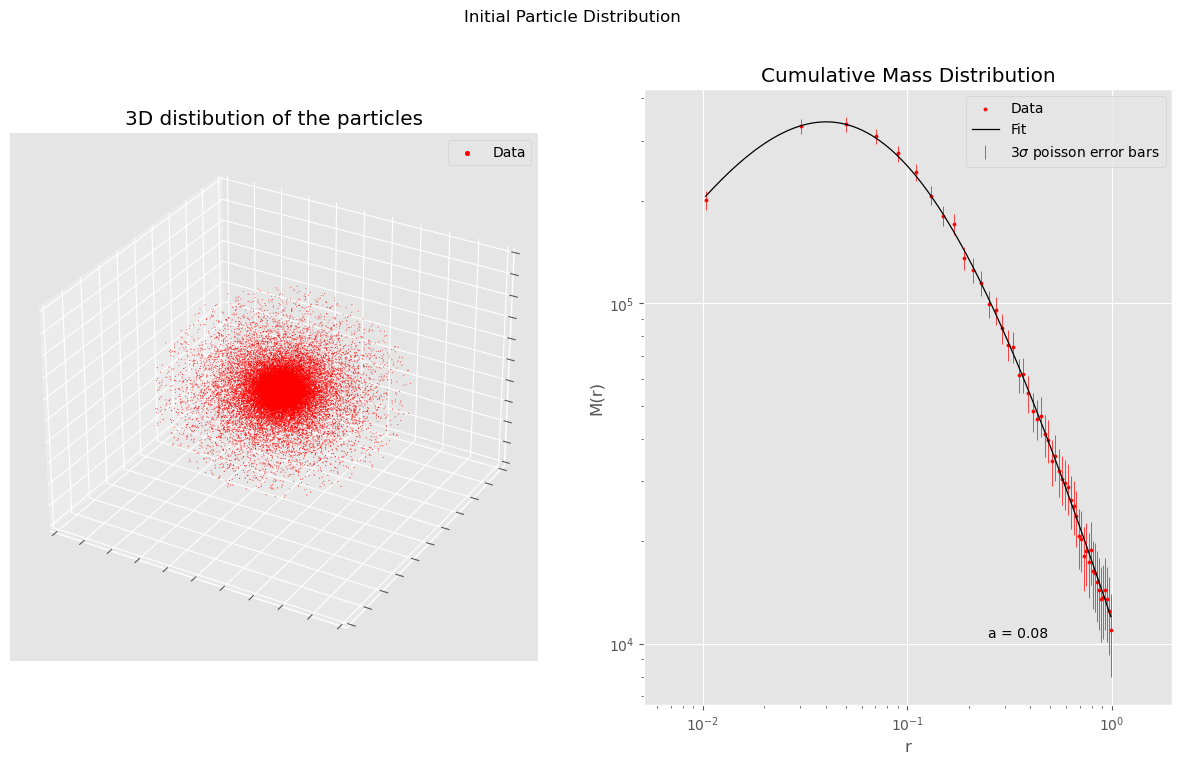

In [30]:
NBINS = 50

df_to_plot = particles_data[particles_data["r"]<1]

#3d scatter of the data
plt.figure(figsize=(15, 8))
plt.suptitle("Initial Particle Distribution")
grid = GridSpec(1, 2, hspace=1)
plt.subplot(grid[0], projection="3d")
plt.title("3D distibution of the particles")
plt.gca().scatter(df_to_plot["x"], df_to_plot["y"], df_to_plot["z"], color='red', s=0.1)
plt.gca().scatter([],[],[], label="Data", color='red', s=10)
plt.legend()
plt.xticks(plt.xticks()[0], [])
plt.yticks(plt.yticks()[0], [])
plt.gca().set_zticks(plt.gca().get_zticks(), [])

plt.subplot(grid[1])

# we need this data if we want to do a fit
hist, bin_edges = np.histogram(df_to_plot["r"], bins=NBINS, weights=df_to_plot["m"])
bin_centers = (bin_edges[1:] + bin_edges[:-1]) / 2


M = df["m"].sum()
def rho(r, a):
    rho_r = M / (2*np.pi) * (a/r) * 1/((r+a)**3)
    return rho_r * 4*np.pi*r**2 * 1/NBINS

x = np.linspace(min(bin_centers), max(bin_centers), 1000)
a, _ = curve_fit(rho, bin_centers, hist)
a = a[0]

# count the number of particles in each bin

plt.title("Cumulative Mass Distribution")


plt.scatter(bin_centers, hist, color='red', s=5, label="Data")

errors = np.sqrt(hist / (M/len(df))) * M/len(df) * 3 # sigma = sqrt(N)
plt.errorbar(bin_centers, hist, yerr=errors, fmt='none', color='red', elinewidth=0.5, label = "$3\sigma$ poisson error bars") # we don't see a thing...

plt.plot(x, rho(x, a), label="Fit", color='black', linewidth=0.9)
#errors = np.sqrt(rho(x, a))*5
#plt.fill_between(x, rho(x, a)-errors, rho(x, a)+errors, alpha=0.3, color='black')
plt.text(0.65, 0.11, f"a = {a:.2f}", transform=plt.gca().transAxes)

plt.xlabel("r")
plt.ylabel("M(r)")
plt.xlim(np.min(x)/2, np.max(x)*2)

plt.xscale("log")
plt.yscale("log")

plt.legend()
plt.show()

Voilà qui est fait ! Maintenant, parlons un peu des unités. En gros, si on veut simuler des galaxies, les grandeurs de masse et de distance sont à peu près fixées:

\begin{align*}
M_{tot} &= 10^{10} M_{\odot}\\
R &= 40 kpc
\end{align*}

Là on ne se pose pas vraiment de question. L'inconnue c'est plutôt le pas de temps. En effet, si on utilise $G \approx 10^{-11}$, on va devoir attendre des milliards d'années pour voir la galaxie évoluer. On décide plutôt de fixer $G=1$. La dimension du temps sera alors bien plus raisonnable, ce qu'on constate après une simple analyse dimensionnelle. On se rappelle de la formule de la *typical particle velocity*:

$$
v = \sqrt{\frac{GM_{tot}}{R}}
$$

Le temps caractéristique de collision de deux particules était alors $t_{cross} = \frac{R}{v} = \frac{R^{3/2}}{\sqrt{GM_{tot}}}$ (pour rappel, le temps de relaxation est proportionnel à $t_{cross}$ et au nombre de particules). En fixant G=1, on choisit d'exprimer le temps caractéristique :

$$
t_{cross} = \sqrt{\frac{R^3}{M_{tot}}}
$$

Mais bon en vrai je comprends pas trop ce qu'on est censé dire à partir de là...

### 1.2. Deuxième Étape

* [ ] Calculer les forces appliquées à chaque particule de manière directe (avec $\epsilon$). Tester pour différentes valeurs de $\epsilon$.
* [ ] Comparer des calculs directs de forces à la solution exacte donnée par le livre *Galactic Dynamics* (aussi appelée **loi de Gauss** cf ci-dessus, on a déjà la valeur de la Force).
* [ ] Calculer le temps de relaxation du system et commenter le lien avec $\epsilon$.

Pour ça, on va avoir besoin d'un calcul direct des forces. Le script en Python part pour 44h (à cause de `iterrows` je crois, en vrai ça doit pas être si long que ça), donc ça ne va pas le faire. On va préférer créer un programme en C++ qui exportera le résultat dans un fichier.

Commençons par tester la méthode de calcul direct combinée avec la méthode d'Euler. On peut tester ça tout d'abord sur un problème à trois corps stable.

Dataframe loaded with shape (15003, 9)


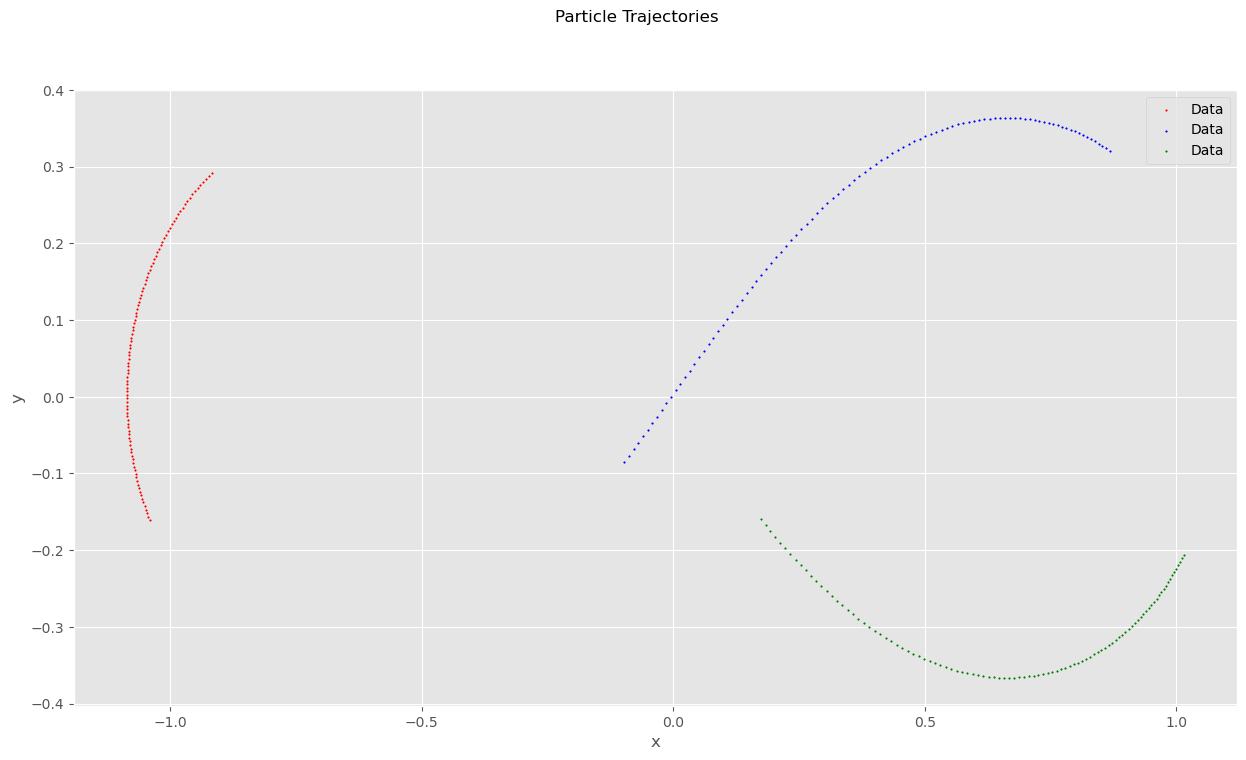

In [5]:
with open("../files/direct_N_part_trajectory.txt", 'r') as f:
    data = []
    lines = f.readlines()
    for line in lines:
        numbers = [float(x.strip()) for x in line.split() if x.strip()]
        data.extend(numbers[1:]) # first is index => we don't care
    columns = ["m", "x", "y", "z", "vx", "vy", "vz", "eps", "phi"] # last two are sftening and potential => we actually don't care
    df = pd.DataFrame(np.array(data).reshape(-1, len(columns)), columns=columns)

print("Dataframe loaded with shape", df.shape)
start_time = 1000
n_traj = 100 # how many point we draw for each particle

# let's make the plot!
start_time = start_time - start_time%3

df_frame = df.iloc[start_time:start_time+3*n_traj]
df1 = df_frame.iloc[::3]
df2 = df_frame.iloc[1::3]
df3 = df_frame.iloc[2::3]

fig = plt.figure(figsize=(15, 8))
plt.suptitle("Particle Trajectories")
plt.scatter(df1["x"], df1["y"], color='red', s=1, label="Data")
plt.scatter(df2["x"], df2["y"], color='blue', s=1, label="Data")
plt.scatter(df3["x"], df3["y"], color='green', s=1, label="Data")
plt.legend()
plt.xlabel("x")
plt.ylabel("y")
plt.show()

Ca a l'air de bien marcher ! Maintenant, on peut tester le calcul directe des forces sur les particules fournies par le prof. Il va falloir s'accrocher un peu parce qu'on a beaucoup de choses à calculer.

In [6]:
#####################
### Load Datasets ###
#####################

files = [
    "forces_eps=0.000000.txt",
    "forces_eps=1.000000.txt",
    "forces_eps=0.100000.txt",
    "forces_eps=0.010000.txt",
    "forces_eps=0.001000.txt",
]
file = files[4]

with open("../files/data.txt", 'r') as f:
    data = []
    lines = f.readlines()
    for line in lines:
        numbers = [float(x.strip()) for x in line.split() if x.strip()]
        data.extend(numbers[1:]) # first is index => we don't care
    columns = ["m", "x", "y", "z", "vx", "vy", "vz", "eps", "phi"] # last two are sftening and potential => we actually don't care
    df = pd.DataFrame(np.array(data).reshape(-1, len(columns)), columns=columns)
    df["r"] = np.sqrt(df["x"]**2 + df["y"]**2 + df["z"]**2) 

with open(f"../files/{file}", 'r') as f:
    data = []
    lines = f.readlines()
    for line in lines:
        if not line:
            continue
        numbers = [float(x.strip()) for x in line.split() if x.strip()]
        data.extend(numbers[1:]) # first is index => we don't care
    columns = ["fx", "fy", "fz"] # last two are sftening and potential => we actually don't care
    df_forces = pd.DataFrame(np.array(data).reshape(-1, len(columns)), columns=columns)

len(df), len(df_forces)

(50010, 50010)

In [7]:
df = pd.concat([df, df_forces], axis=1)

La question maitenant, c'est que faire de ça ? Que souhaite-t-on comparer, calculer ? L'idée ça va être de faire comme la distribution ci-dessus, mais à la place de compter les particules, on choisira une grandeur intéressante (par exemple $\vec{F} \cdot \vec{u}_r$) et on la moyennera ! Commençons donc par calculer les grandeurs intéressantes.

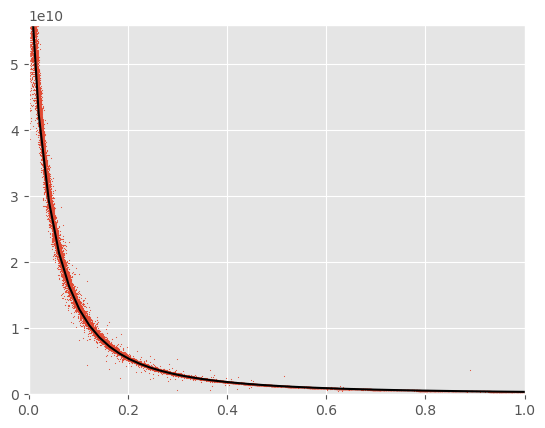

In [8]:
# radial component of the force
df["fr"] = (df["fx"] * df["x"] + df["fy"] * df["y"] + df["fz"] * df["z"]) / df["r"]
M = df["m"].sum()
m = df["m"].mean()

plt.scatter(df["r"], -df["fr"], s=0.1, label="$-\vec{F} \cdot \vec{u}_r$")

# theoretical curve
def f(r, a=0.08):
    return -M*m / (r+a)**2

r = np.linspace(0, 1)
plt.plot(r, -f(r), label="Theory", color='black')

plt.xlim(0, 1)
plt.ylim(0, -df["fr"].quantile(0.01))
plt.show()

Bon, maintenant, l'idée c'est d'étudier comment la courbe évolue avec le *softening*. Le softening, ça va, je suppose, éviter les anomalies et e quelque sorte faire une moyenne de l'entourage de l'élément. En effet, être proche ou presque proche, ça devient pareil tant que c'est moins que le softening.

Bref, ce qui nous intéresse c'est comment les propriétés locales vont dépendre du softening. Donc, on va regarder la deviation par rapport à la courbe théorique.

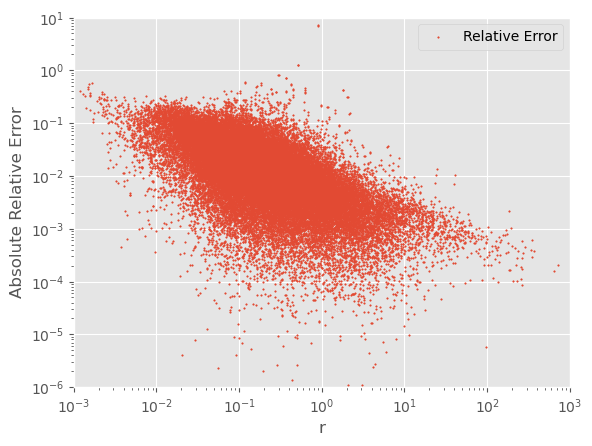

In [9]:
df["theoretical_fr"] = f(df["r"])
df["relative_error"] = ((df["theoretical_fr"] - df["fr"]) / df["theoretical_fr"]).abs()

plt.scatter(df["r"], df["relative_error"], s=1, label="Relative Error")
plt.yscale("log")
plt.xscale("log")
plt.xlim(1e-3, 1e3)
plt.ylim(1e-6, 10)
plt.xlabel("r")
plt.ylabel("Absolute Relative Error")
plt.legend()
plt.show()

Essayons pour différent epsilons. Bon c'est sympa, je sais pas trop quoi dire, mais on va pouvoir passer à la suite.

## 2. Second Task: tree-code


### 2.1. Force Calculations
* [ ] code the multipole expansion
* [X] create the tree
* [X] decide on a distance based criterion
* [ ] compute force, compare with the correct result, and compare computationnal cost.
* [ ] compare result with direct summation, try different opening angles and different softening

Bon, on va commencer par quelques calculs. Supposons qu'on souhaite calculer la force qui va s'appliquer à une particule $\mathcal{P}(\vec{r})$. Au loin, on un tout un tas the $n$ particules dont on souhaite calculer l'influence gravitationnelle en groupe. En d'autres termes, on souhaite calculer l'influence de ce groupe de particule à une distance $r$. La formule exacte pour le potentiel est la suivante :
$$
\phi(\vec{r}) = -G \sum_{k=1}^{n} \frac{m_k}{\left|\vec{r} - \vec{r_k} \right|}
$$

Le problème, c'est que dans ce cas, on a pour chaque particule une somme de n = O(N) termes à faire $\implies$ au total O(N^2). L'idée c'est d'approximer ce potentiel par la formule suivante :
$$
\phi(\vec{r}) \approx -G \frac{M_{tot}}{\left|\vec{r} - \vec{R}_{COM}\right|}

- \frac{G}{2} \sum_{\alpha, \beta}^{3} \frac{Q_{\alpha \beta}(r_\alpha - R_{COM,\alpha})(r_{\beta} - R_{COM,\beta})}{\left|\vec{r} - \vec{R}_{COM} \right|^5}\\
= -G \frac{M_{tot}}{\left|\vec{r} - \vec{R}_{COM}\right|}

- \frac{G}{2} \sum_{\alpha, \beta}^{3} \frac{(\vec{r} - \vec{R}_{COM})^T Q (\vec{r} - \vec{R}_{COM})}{\left|\vec{r} - \vec{R}_{COM} \right|^5}
$$

Il n'y plus qu'à en prendre le gradient:
$$
\vec{F} = -\vec{\nabla}\phi(\vec{r}) \\
$$
et on obtient:
$$
\vec{F} = -G \frac{M}{\left(\vec{r} - \vec{R}_{COM}\right)^2} \frac{\vec{r}}{\left| \vec{r} \right|} - \frac{G}{2}...
$$

Let's compute the derivatives of the quadrupole term ($\nabla = \frac{\partial}{\partial r_{\mu}} = \frac{\partial}{\partial \tilde{r}_{\mu}}$ with $\tilde{r} = \vec{r} - \vec{R}_{COM}$):
\begin{align*}
\frac{\partial}{\partial r_{\mu}} Q_{\alpha,\beta}\tilde{r}^\alpha \tilde{r}^\beta &= Q_{\alpha,\beta}(\frac{\partial}{\partial r_{\mu}}\tilde{r}^\alpha) \tilde{r}^\beta + Q_{\alpha,\beta} \tilde{r}^\alpha (\frac{\partial}{\partial r_{\mu}}\tilde{r}^\beta)\\
 &= Q_{\mu,\beta} \tilde{r}^\beta + Q_{\alpha,\mu} \tilde{r}^\alpha \\
 &= 2 Q_{\mu,\beta} \tilde{r}^\beta \ \text{since Q is symetric}
\end{align*}

Thus:
$$
\frac{\partial}{\partial \tilde{r}} (\tilde{r}^T Q r) = 2Qr
$$

We need one last derivative:
$$
\frac{\partial}{\partial \tilde{r}} \left| \tilde{r} \right|^5 = 5\left|\tilde{r}\right|^4 \frac{\vec{\tilde{r}}} {\left| \tilde{r} \right|} = 5 \left|\tilde{r}\right|^3 \vec{\tilde{r}}
$$

The derivative of the full quotient is thus:

$$
\frac{\partial}{\partial \tilde{r}}(...) = \frac{
    2Q\tilde{r} \cdot \left|\tilde{r}\right|^5 + 5 (\tilde{r}^{T}Q\tilde{r}) \left| \tilde{r} \right| ^3 \tilde{r}
}{
    \left| \tilde{r} \right| ^{10}
}
$$

Thus we finally get:
$$
\vec{F} = -G \frac{M}{\tilde{r}^2} \frac{\vec{r}}{\left| \vec{r} \right|} - \frac{G}{2} \left[ \frac{
    2Q
}{
    \left| \tilde{r} \right| ^{4}
} + \frac{
    5 (\tilde{r}^{T}Q\tilde{r}) 
}{
    \left| \tilde{r} \right| ^{6}
} \right] \frac{\tilde{r}}{\left| \tilde{r} \right|}
$$

with $\tilde{r} = \vec{r} - \vec{R}_{COM}$. All the quadrupole terms are indeed $\propto \frac{1}{r^4}$.

Let's start by testing our `Tree` implementation.

In [17]:
tree_data = pd.read_csv("../files/tree_data.csv")
print("Tree data collected:", tree_data.shape)

# let's find the depth of the tree by looking at the smallest halfwidth
print("Depth of the tree:", np.round(-np.log(tree_data["halfWidth"].min()) / np.log(2)).astype(int))


# now let's look at our particles
particles = pd.read_csv("../files/data.txt", sep="\s+", header=None, names=["index", "m", "x", "y", "z", "vx", "vy", "vz", "eps", "phi"])
print("Particles data collected:", particles.shape)
particles["r"] = np.sqrt(particles["x"]**2 + particles["y"]**2 + particles["z"]**2)

direct_forces = pd.read_csv("../files/forces_eps=0.000000.txt", sep=" ", header=None, names=["index", "fd_x", "fd_y", "fd_z"])
print("Direct force data collected:", direct_forces.shape)

force_octree = pd.read_csv("../files/forces_octree.txt", sep=" ", header=None, names=["index", "fo_x", "fo_y", "fo_z"])
print("Force octree data collected:", force_octree.shape)

df = pd.concat([particles, direct_forces, force_octree], axis=1)
df["fd_r"] = (df["fd_x"] * df["x"] + df["fd_y"] * df["y"] + df["fd_z"] * df["z"]) / df["r"]
df["fo_r"] = (df["fo_x"] * df["x"] + df["fo_y"] * df["y"] + df["fo_z"] * df["z"]) / df["r"]

Tree data collected: (170249, 8)
Depth of the tree: 14
Particles data collected: (50010, 10)
Direct force data collected: (50010, 4)
Force octree data collected: (50010, 4)


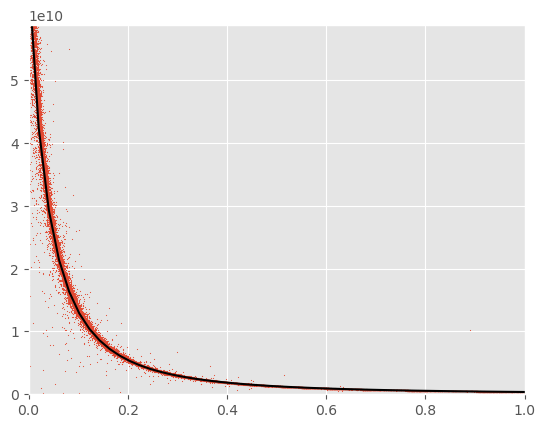

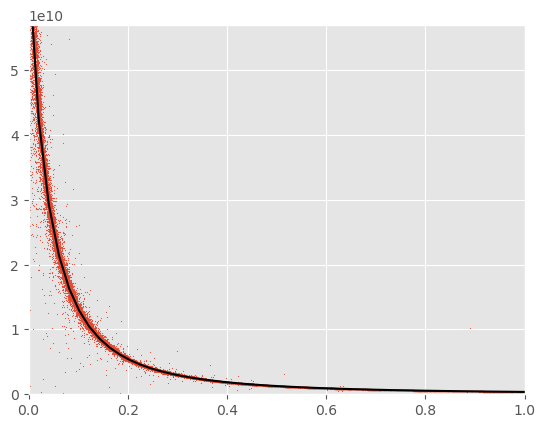

-0.014538491352554422

In [23]:
# radial component of the force
M = df["m"].sum()
m = df["m"].mean()

plt.scatter(df["r"], -df["fd_r"], s=0.1, label="$-\vec{F} \cdot \vec{u}_r$")

# theoretical curve
def f(r, a=0.08):
    return -M*m / (r+a)**2

r = np.linspace(0, 1)
plt.plot(r, -f(r), label="Theory", color='black')

plt.xlim(0, 1)
plt.ylim(0, -df["fd_r"].quantile(0.01))
plt.show()


# radial component of the force
M = df["m"].sum()
m = df["m"].mean()

plt.scatter(df["r"], -df["fo_r"], s=0.1, label="$-\vec{F} \cdot \vec{u}_r$")

# theoretical curve
def f(r, a=0.08):
    return -M*m / (r+a)**2

r = np.linspace(0, 1)
plt.plot(r, -f(r), label="Theory", color='black')

plt.xlim(0, 1)
plt.ylim(0, -df["fo_r"].quantile(0.01))
plt.show()


((df["fo_r"] - df["fd_r"]) / df["fd_r"]).mean()

In [ ]:
tree_data.head()

,x,y,z,halfWidth,totalMass,centerOfMass_x,centerOfMass_y,centerOfMass_z
0,0.000,0.000,0.000,1.000,4.076810e+06,-0.000897,-0.000650,-0.000124
1,-0.500,-0.500,-0.500,0.500,5.192490e+05,-0.128624,-0.124222,-0.128200
2,-0.750,-0.750,-0.750,0.250,1.848520e+03,-0.701561,-0.754629,-0.685952
3,-0.875,-0.875,-0.875,0.125,9.242590e+01,-0.758008,-0.990816,-0.899745
4,-0.625,-0.875,-0.875,0.125,1.848520e+02,-0.635672,-0.846156,-0.840716


In [ ]:
tree_data = pd.read_csv("../files/tree_for_test_octree.csv")
particles_data = pd.read_csv("../files/particles_for_test_octree.txt", sep=" ", header=None)
particles_data.columns = ["index", "m", "x", "y", "z", "vx", "vy", "vz", "eps", "phi"]

print("Tree: ", tree_data.shape)    
print("Particles: ", particles_data.shape)

Tree:  (33, 8)
Particles:  (4, 10)


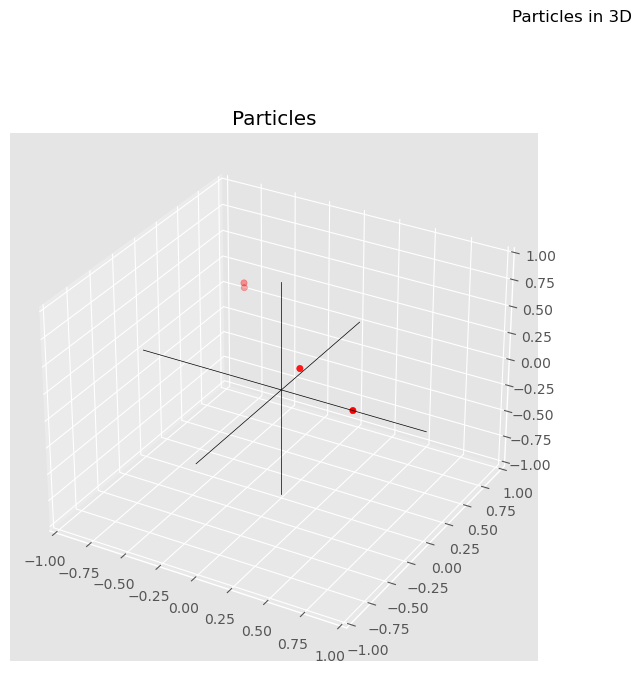

In [ ]:
# let's plot the particles in 3D between -1 and 1
plt.figure(figsize=(15, 8))
plt.suptitle("Particles in 3D")
ax = plt.subplot(121, projection="3d")
ax.set_title("Particles")
ax.scatter(particles_data["x"], particles_data["y"], particles_data["z"], color='red')
plt.xlim(-1, 1)
plt.ylim(-1, 1)
ax.set_zlim(-1, 1)

plt.plot([-1, 1], [0, 0], [0, 0], color='black', linewidth=0.5)
plt.plot([0, 0], [-1, 1], [0, 0], color='black', linewidth=0.5)
plt.plot([0, 0], [0, 0], [-1, 1], color='black', linewidth=0.5)

# let's plot the tree => plot every

plt.show()

### 2.2. Time integrator

* [ ] Do it over a few crossing timescales. 
* [ ] Try different softenings. 
* [ ] Attempt to measure the **numerical relaxation**. Compare with softenings.
* [ ] Try different timesteps, justifying the choice.

### 2.3. Full gravity tree solver scheme
* [ ] evolve for at least a few timesteps 